# Crucible 4: Sky Map at Step 5000

**Purpose:** Visualize the 64D token space at training step 5000 using spherical coordinates.

**Questions:**
1. Where do live and dead tokens cluster in angular space?
2. Does h_mean point toward the live centroid?
3. Are live tokens packed into a tight angular cone (explaining why small autocorr changes = "big swings")?
4. Is the dead cloud antipodal to h_mean?

**Method:** Use PCA to find principal directions of W[5000], project onto spherical coordinates, plot on Mollweide projection (like star charts).

## Parameters

In [43]:
# Which training step to visualize
T_STEP = 5000

# PCA basis selection (1-indexed)
NORTH_PC = 2      # North pole (+90° latitude)
MERIDIAN_PC = 1   # Prime meridian (0° longitude)
EQUINOX_PC = 3    # Equinox (+90° longitude)

# Visualization
POINT_SIZE = 20
POINT_ALPHA = 0.3
FIGSIZE = (18, 9)
DPI = 200

## Imports

In [44]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

# Random seed
torch.manual_seed(42)
np.random.seed(42)

## Load Data

In [45]:
PROJECT_ROOT = Path.cwd().parent.parent.parent.parent
DATA_PATH = PROJECT_ROOT / 'box_4' / 'tensors' / 'Crucible-4' / 'crucible_4_trajectory.safetensors'

print(f"Loading data from {DATA_PATH}")
data = load_file(str(DATA_PATH))

# W at step T_STEP (stored as uint16, view as bfloat16, convert to float32)
W = data['W'][T_STEP].view(torch.bfloat16).float()  # (10000, 64)
h_mean = data['h_mean'][T_STEP - 1].float()  # (64,) - h_mean indexed from 0
dead_mask = data['dead_mask'].bool()
live_mask = ~dead_mask

print(f"\nLoaded step {T_STEP}:")
print(f"  W: {W.shape}")
print(f"  h_mean: {h_mean.shape}")
print(f"  Dead tokens: {dead_mask.sum().item()}")
print(f"  Live tokens: {live_mask.sum().item()}")

Loading data from /Users/jefferyharrell/Projects/Azimuth_II/box_4/tensors/Crucible-4/crucible_4_trajectory.safetensors

Loaded step 5000:
  W: torch.Size([10000, 64])
  h_mean: torch.Size([64])
  Dead tokens: 3699
  Live tokens: 6301


## Separate Populations

In [46]:
W_dead = W[dead_mask]  # (3699, 64)
W_live = W[live_mask]  # (6301, 64)

centroid_dead = W_dead.mean(dim=0)  # (64,)
centroid_live = W_live.mean(dim=0)  # (64,)

print(f"Dead population: {W_dead.shape[0]} tokens")
print(f"  Centroid norm: {torch.norm(centroid_dead).item():.6f}")

print(f"\nLive population: {W_live.shape[0]} tokens")
print(f"  Centroid norm: {torch.norm(centroid_live).item():.6f}")

print(f"\nh_mean:")
print(f"  Norm: {torch.norm(h_mean).item():.6f}")

print(f"\nSeparation:")
separation = torch.norm(centroid_dead - centroid_live).item()
print(f"  ||centroid_dead - centroid_live||: {separation:.6f}")

Dead population: 3699 tokens
  Centroid norm: 0.660039

Live population: 6301 tokens
  Centroid norm: 0.175193

h_mean:
  Norm: 5.246673

Separation:
  ||centroid_dead - centroid_live||: 0.519505


## Compute PCA

Use full W matrix (all tokens) to define coordinate system.

In [47]:
print("Computing PCA...")

# Center the data
W_centered = W - W.mean(dim=0)

# Covariance matrix
N = W.shape[0]
cov = (W_centered.T @ W_centered) / N

# Eigendecomposition
eigenvalues, eigenvectors = torch.linalg.eigh(cov)

# Sort descending
idx = torch.argsort(eigenvalues, descending=True)
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

print(f"\n✓ PCA computed")
print(f"  Top 3 eigenvalues:")
for i in range(3):
    var_explained = eigenvalues[i] / eigenvalues.sum() * 100
    print(f"    PC{i+1}: λ = {eigenvalues[i]:.6f} ({var_explained:.2f}% variance)")

Computing PCA...

✓ PCA computed
  Top 3 eigenvalues:
    PC1: λ = 0.091004 (14.64% variance)
    PC2: λ = 0.047792 (7.69% variance)
    PC3: λ = 0.047101 (7.58% variance)


## Define Spherical Basis

In [48]:
def get_pc_vector(pcs, index):
    """Get PC vector by index (1-indexed), with sign flip for negative indices."""
    pc_num = abs(index) - 1
    vector = pcs[:, pc_num].clone()
    if index < 0:
        vector = -vector
    return vector

north = get_pc_vector(eigenvectors, NORTH_PC)
meridian = get_pc_vector(eigenvectors, MERIDIAN_PC)
equinox = get_pc_vector(eigenvectors, EQUINOX_PC)

print("Spherical coordinate basis:")
print(f"  North (+Z, north pole):    PC{NORTH_PC}")
print(f"  Meridian (+X, 0° lon):     PC{MERIDIAN_PC}")
print(f"  Equinox (+Y, 90° lon):     PC{EQUINOX_PC}")

Spherical coordinate basis:
  North (+Z, north pole):    PC2
  Meridian (+X, 0° lon):     PC1
  Equinox (+Y, 90° lon):     PC3


## Project Tokens to Spherical Coordinates

In [49]:
def to_spherical(vectors, north, meridian, equinox):
    """Project vectors to spherical coordinates.
    
    Returns:
        lat_deg: Latitude in degrees [-90, 90]
        lon_deg: Longitude in degrees [-180, 180]
    """
    x = vectors @ meridian
    y = vectors @ equinox
    z = vectors @ north
    
    r = torch.sqrt(x**2 + y**2 + z**2)
    
    lat_rad = torch.asin(torch.clamp(z / r, -1, 1))
    lon_rad = torch.atan2(y, x)
    
    return torch.rad2deg(lat_rad), torch.rad2deg(lon_rad)

# Project tokens
lat_dead, lon_dead = to_spherical(W_dead, north, meridian, equinox)
lat_live, lon_live = to_spherical(W_live, north, meridian, equinox)

# Project centroids and h_mean
lat_centroid_dead, lon_centroid_dead = to_spherical(centroid_dead.unsqueeze(0), north, meridian, equinox)
lat_centroid_live, lon_centroid_live = to_spherical(centroid_live.unsqueeze(0), north, meridian, equinox)
lat_h_mean, lon_h_mean = to_spherical(h_mean.unsqueeze(0), north, meridian, equinox)

print("\n✓ Spherical coordinates computed")
print(f"\nDead tokens:")
print(f"  Lat range: [{lat_dead.min():.2f}°, {lat_dead.max():.2f}°]")
print(f"  Lon range: [{lon_dead.min():.2f}°, {lon_dead.max():.2f}°]")

print(f"\nLive tokens:")
print(f"  Lat range: [{lat_live.min():.2f}°, {lat_live.max():.2f}°]")
print(f"  Lon range: [{lon_live.min():.2f}°, {lon_live.max():.2f}°]")

print(f"\nDead centroid: ({lat_centroid_dead[0].item():.2f}°, {lon_centroid_dead[0].item():.2f}°)")
print(f"Live centroid: ({lat_centroid_live[0].item():.2f}°, {lon_centroid_live[0].item():.2f}°)")
print(f"h_mean:        ({lat_h_mean[0].item():.2f}°, {lon_h_mean[0].item():.2f}°)")


✓ Spherical coordinates computed

Dead tokens:
  Lat range: [-19.79°, -13.18°]
  Lon range: [-5.48°, 0.51°]

Live tokens:
  Lat range: [-88.82°, 88.72°]
  Lon range: [-179.99°, 179.89°]

Dead centroid: (-16.80°, -2.55°)
Live centroid: (-38.64°, 0.39°)
h_mean:        (10.24°, 175.48°)


## Sky Map: Live vs Dead

Mollweide projection (like astronomical star charts). Black background.

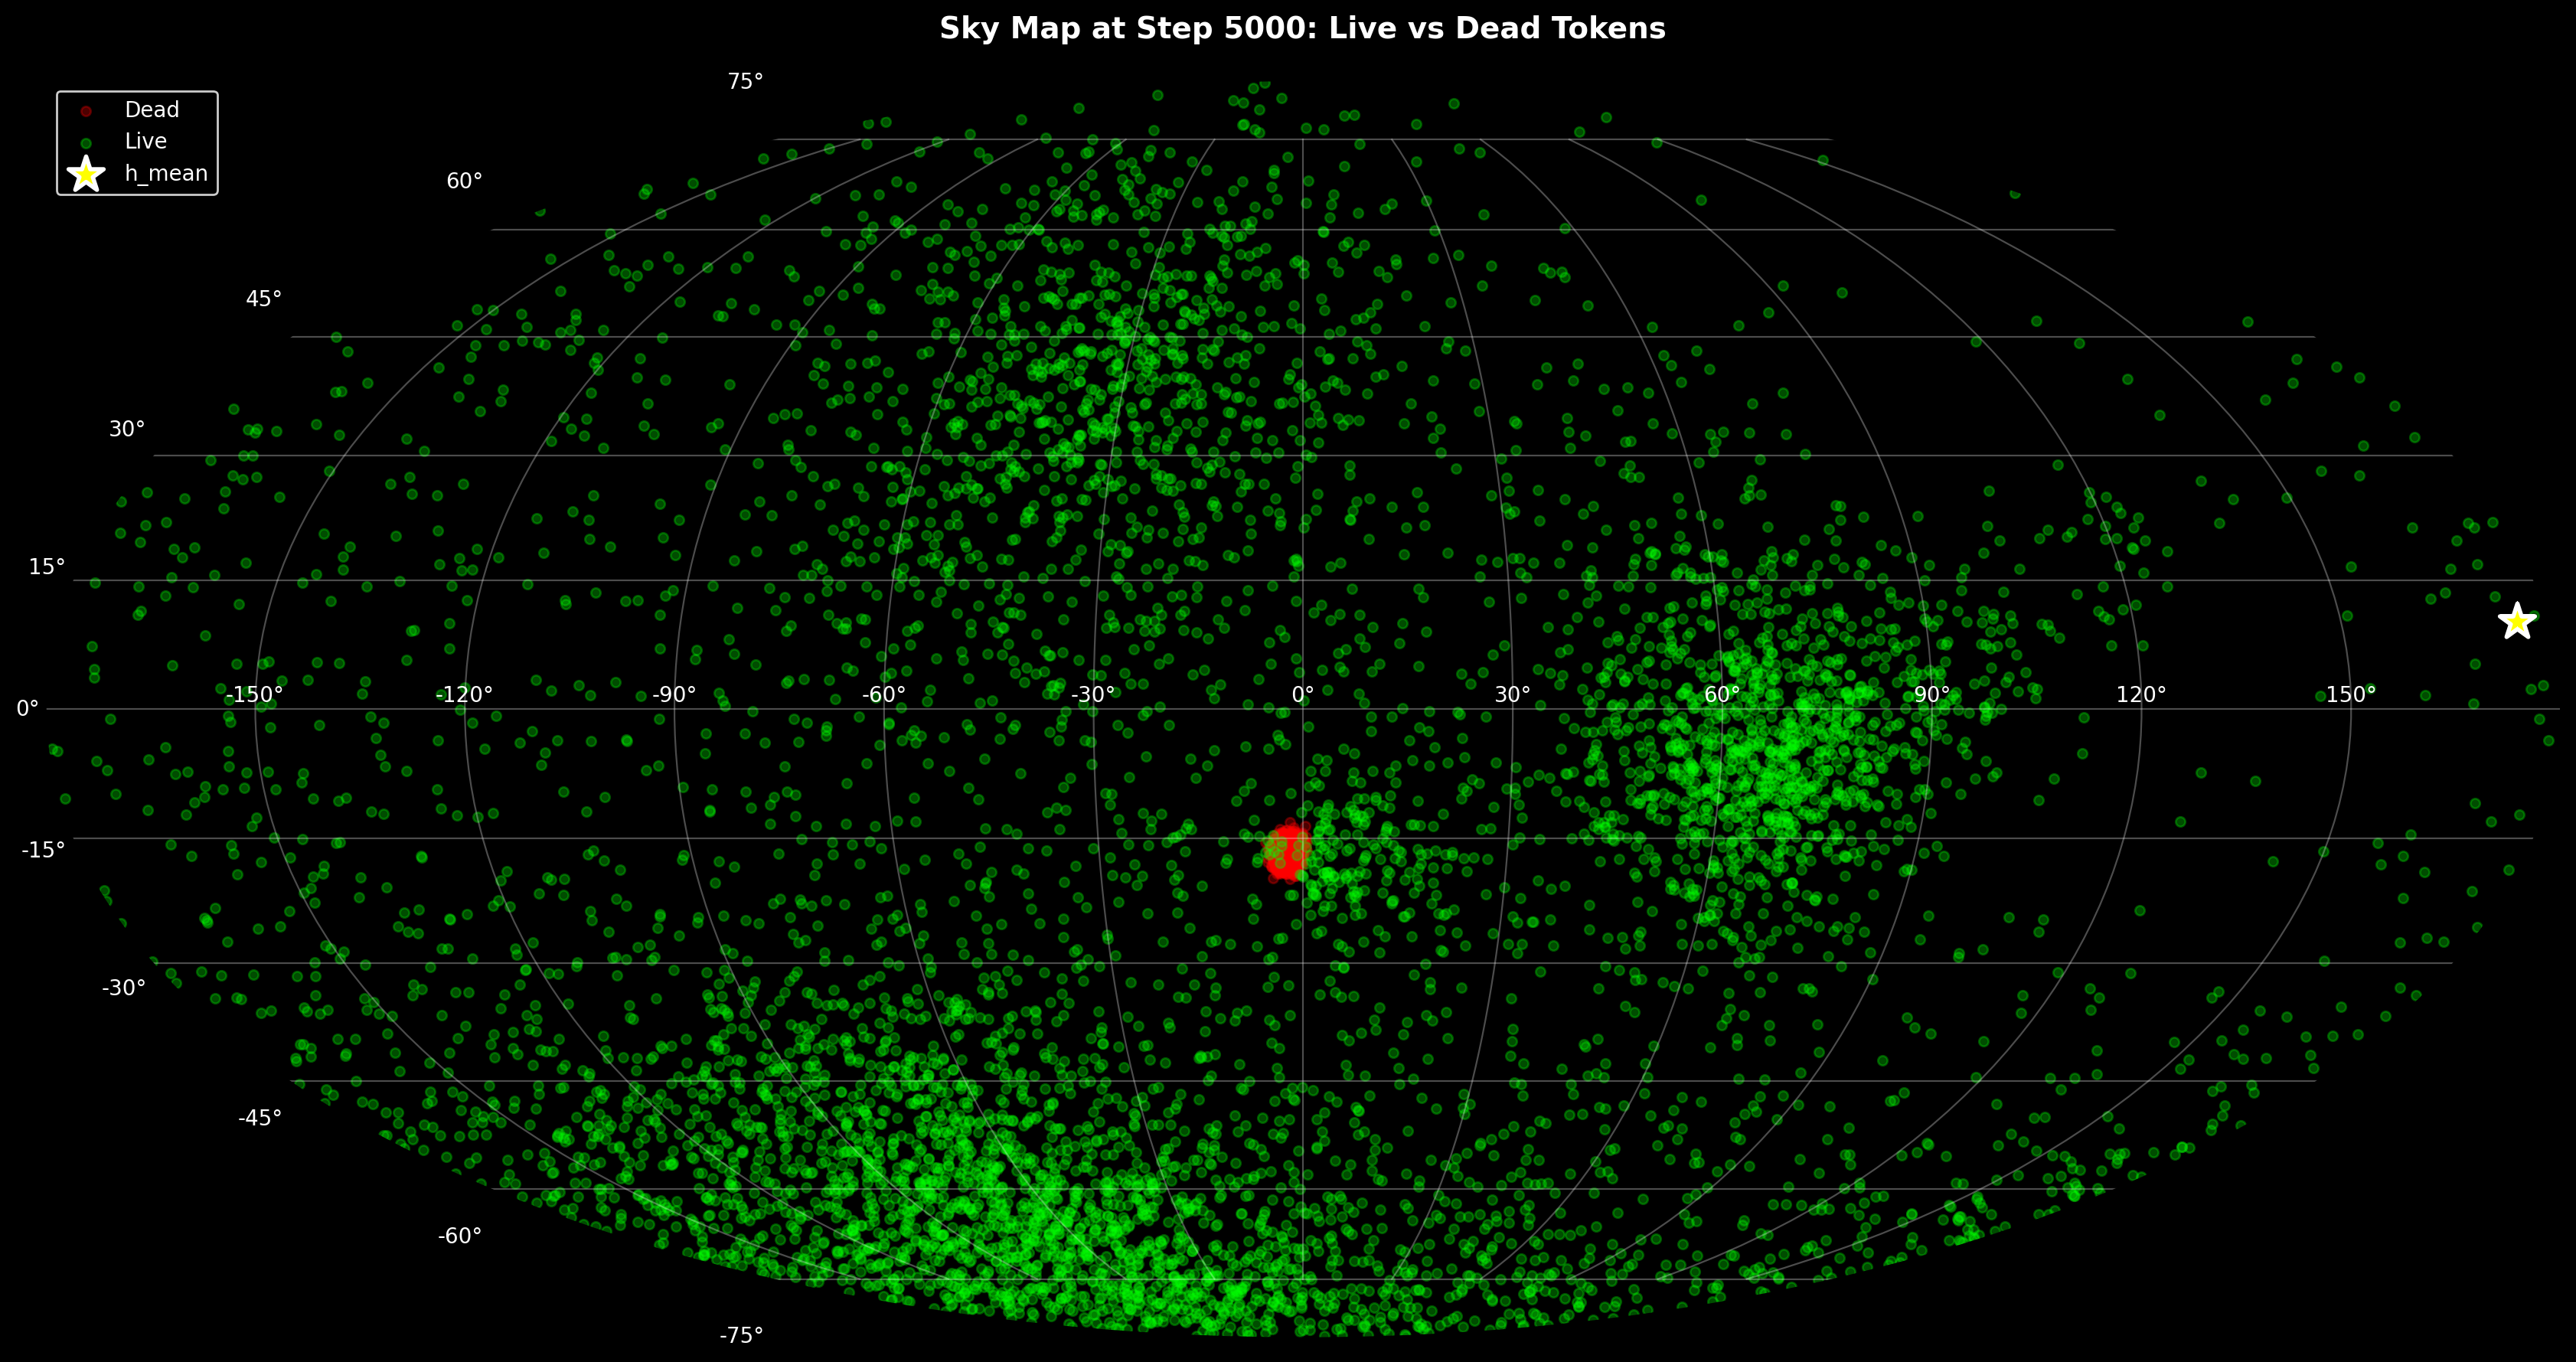

In [50]:
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)
ax = fig.add_subplot(111, projection='mollweide')
ax.set_facecolor('black')
fig.patch.set_facecolor('black')

# Plot tokens
ax.scatter(np.deg2rad(lon_dead.numpy()), np.deg2rad(lat_dead.numpy()),
           s=POINT_SIZE, alpha=POINT_ALPHA, c='red', label='Dead', rasterized=True)
ax.scatter(np.deg2rad(lon_live.numpy()), np.deg2rad(lat_live.numpy()),
           s=POINT_SIZE, alpha=POINT_ALPHA, c='lime', label='Live', rasterized=True)

# Plot centroids (larger)
# ax.scatter(np.deg2rad(lon_centroid_dead[0].numpy()), np.deg2rad(lat_centroid_dead[0].numpy()),
#            s=200, c='red', marker='X', edgecolors='white', linewidths=2, 
#            label='Dead Centroid', zorder=10)
# ax.scatter(np.deg2rad(lon_centroid_live[0].numpy()), np.deg2rad(lat_centroid_live[0].numpy()),
#            s=200, c='lime', marker='X', edgecolors='white', linewidths=2, 
#            label='Live Centroid', zorder=10)

# Plot h_mean (distinct marker)
ax.scatter(np.deg2rad(lon_h_mean[0].numpy()), np.deg2rad(lat_h_mean[0].numpy()),
           s=300, c='yellow', marker='*', edgecolors='white', linewidths=2, 
           label='h_mean', zorder=11)

# Formatting
ax.grid(True, alpha=0.3, color='white')
ax.set_title(f'Sky Map at Step {T_STEP}: Live vs Dead Tokens', 
             color='white', pad=20, fontsize=14, fontweight='bold')

# Legend
legend = ax.legend(loc='upper left', fontsize=10, framealpha=0.8)
legend.get_frame().set_facecolor('black')
legend.get_frame().set_edgecolor('white')
for text in legend.get_texts():
    text.set_color('white')

# Tick colors
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_color('white')

plt.tight_layout()
plt.show()

## Angular Analysis: h_mean vs Centroids

Compute angular distances (great circle distances) between key points.

In [51]:
def angular_distance(v1, v2):
    """Compute angular distance (great circle) in degrees."""
    cos_theta = torch.dot(v1, v2) / (torch.norm(v1) * torch.norm(v2))
    cos_theta = torch.clamp(cos_theta, -1.0, 1.0)
    return torch.rad2deg(torch.acos(cos_theta))

# Compute angles
angle_h_to_live = angular_distance(h_mean, centroid_live)
angle_h_to_dead = angular_distance(h_mean, centroid_dead)
angle_live_to_dead = angular_distance(centroid_live, centroid_dead)

print("=" * 60)
print("ANGULAR ANALYSIS")
print("=" * 60)
print(f"\nh_mean ↔ live centroid:  {angle_h_to_live.item():.2f}°")
print(f"h_mean ↔ dead centroid:  {angle_h_to_dead.item():.2f}°")
print(f"live ↔ dead centroids:   {angle_live_to_dead.item():.2f}°")

# Check if h_mean points toward live (small angle) or dead (large angle)
print(f"\nInterpretation:")
if angle_h_to_live < 30:
    print(f"  ✓ h_mean points TOWARD live centroid (angle = {angle_h_to_live.item():.2f}°)")
elif angle_h_to_live > 150:
    print(f"  ✗ h_mean points AWAY FROM live centroid (angle = {angle_h_to_live.item():.2f}°)")
else:
    print(f"  ? h_mean at intermediate angle to live centroid ({angle_h_to_live.item():.2f}°)")

if abs(angle_live_to_dead - 180) < 30:
    print(f"  ✓ Live/dead centroids are ANTIPODAL (angle = {angle_live_to_dead.item():.2f}°)")
else:
    print(f"  ✗ Live/dead centroids are NOT antipodal (angle = {angle_live_to_dead.item():.2f}°)")

print("\n" + "=" * 60)

ANGULAR ANALYSIS

h_mean ↔ live centroid:  148.67°
h_mean ↔ dead centroid:  164.88°
live ↔ dead centroids:   31.84°

Interpretation:
  ? h_mean at intermediate angle to live centroid (148.67°)
  ✗ Live/dead centroids are NOT antipodal (angle = 31.84°)



## Live Token Angular Spread

How tightly clustered are live tokens in angular space?

In [52]:
# Compute angular distance of each live token from live centroid
centroid_live_normalized = centroid_live / torch.norm(centroid_live)
W_live_normalized = W_live / torch.norm(W_live, dim=1, keepdim=True)

cos_angles = (W_live_normalized @ centroid_live_normalized).clamp(-1, 1)
angles_from_centroid = torch.rad2deg(torch.acos(cos_angles))

print("Live token angular spread (from live centroid):")
print(f"  Mean:   {angles_from_centroid.mean():.2f}°")
print(f"  Median: {angles_from_centroid.median():.2f}°")
print(f"  Std:    {angles_from_centroid.std():.2f}°")
print(f"  Max:    {angles_from_centroid.max():.2f}°")

# What fraction of live tokens are within small angular cones?
for cone_angle in [5, 10, 20, 30, 45]:
    fraction = (angles_from_centroid < cone_angle).float().mean()
    print(f"  Within {cone_angle}°: {fraction.item()*100:.1f}%")

Live token angular spread (from live centroid):
  Mean:   77.92°
  Median: 77.22°
  Std:    12.22°
  Max:    144.58°
  Within 5°: 0.0%
  Within 10°: 0.0%
  Within 20°: 0.0%
  Within 30°: 0.0%
  Within 45°: 0.7%


## Summary

In [53]:
print("=" * 70)
print(f"SKY MAP SUMMARY (Step {T_STEP})")
print("=" * 70)

print("\n1. DOES H_MEAN POINT TOWARD LIVE CENTROID?")
print(f"   Angle: {angle_h_to_live.item():.2f}°")
if angle_h_to_live < 30:
    print("   ✓ YES - h_mean points at live tokens")
else:
    print("   ✗ NO - h_mean points elsewhere")

print("\n2. ARE LIVE TOKENS TIGHTLY CLUSTERED?")
mean_spread = angles_from_centroid.mean().item()
print(f"   Mean angular spread: {mean_spread:.2f}°")
if mean_spread < 30:
    print("   ✓ YES - packed into tight cone")
    print("   → Small h_mean swings can point at different tokens")
else:
    print("   ✗ NO - spread across wide region")

print("\n3. ARE LIVE/DEAD ANTIPODAL?")
print(f"   Centroid separation: {angle_live_to_dead.item():.2f}°")
if abs(angle_live_to_dead - 180) < 30:
    print("   ✓ YES - tug-of-war geometry confirmed")
else:
    print("   ✗ NO - not opposite directions")

print("\n" + "=" * 70)

SKY MAP SUMMARY (Step 5000)

1. DOES H_MEAN POINT TOWARD LIVE CENTROID?
   Angle: 148.67°
   ✗ NO - h_mean points elsewhere

2. ARE LIVE TOKENS TIGHTLY CLUSTERED?
   Mean angular spread: 77.92°
   ✗ NO - spread across wide region

3. ARE LIVE/DEAD ANTIPODAL?
   Centroid separation: 31.84°
   ✗ NO - not opposite directions

